# Predicting customer lifetime value
Customer lifetime value can be defined as the monetary value of a customer relationship, based on the present value of the projected future cash flows from the customer relationship

Not all customers are equally important to a firm. Maintaining long-term relation with all of them (especially the loss makers) is not optimal because eventually marketing is all about attracting and retaining profitable customers

# Objective
The goal of this project is to build a probabilistic model to determine customer lifetime value
Using the results of this project, managers should be able to: 
* Distinguish active customers from inactive customers
* Generate transaction forecasts for individual customers.

In [12]:
!pip install lifetimes -q    #Install lifetimes python package  -run only once

In [13]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import lifetimes

In [14]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style="ticks")
sns.set_context("poster", font_scale = 0.5, rc={"grid.linewidth": 5})
plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams["figure.dpi"] = 140 

In [50]:
root = '../input/brazilian-ecommerce/'
customers = pd.read_csv(root+'olist_customers_dataset.csv')
orders = pd.read_csv(root+'olist_orders_dataset.csv')
payments = pd.read_csv(root+'olist_order_payments_dataset.csv')

In [51]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [52]:
customers.drop(columns=[i for i in customers.columns if i not in ['customer_id','customer_unique_id']], inplace=True)
customers.set_index('customer_id', inplace=True)

In [53]:
customers.head(1)

,customer_unique_id
customer_id,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0


In [54]:
orders.drop(columns=[i for i in orders.columns if i not in ['customer_id', 'order_id', 'order_purchase_timestamp']], inplace=True)
orders.set_index('customer_id', inplace=True)
orders.drop_duplicates(inplace=True)

In [55]:
orders.head(1)

,order_id,order_purchase_timestamp
customer_id,,
9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33


In [56]:
payments.drop(columns=[i for i in payments.columns if i not in ['order_id', 'payment_value']], inplace=True)
payments.set_index('order_id', inplace=True)
payments.drop_duplicates(inplace=True)

In [57]:
payments.head(1)

,payment_value
order_id,
b81ef226f3fe1789b1e8b2acac839d17,99.33


In [58]:
df = pd.concat([orders,customers], axis=1, join='inner')
df.reset_index(inplace=True)

In [59]:
df['Order_Date'] = pd.to_datetime(pd.to_datetime(df.order_purchase_timestamp).dt.date)
df.head(1)

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,Order_Date
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10-02


In [60]:
df.drop(columns=[i for i in df.columns if i not in ['customer_unique_id','Order_Date']], inplace=True)

In [61]:
df.Order_Date.describe()

count                   99441
unique                    634
top       2017-11-24 00:00:00
freq                     1176
first     2016-09-04 00:00:00
last      2018-10-17 00:00:00
Name: Order_Date, dtype: object

In [67]:
df.customer_unique_id.nunique(), df.shape

(96096, (99441, 2))

# CLV Model Definition

For the CLV models, the following nomenclature is used:
* Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
* T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
* Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

# Data Explore

In [ ]:
from lifetimes.plotting import *
from lifetimes.utils import *

In [77]:
data = summary_data_from_transaction_data(df, 'customer_unique_id', 'Order_Date', observation_period_end='2018-09-28')
data.head(3)

,frequency,recency,T
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,141.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,144.0
0000f46a3911fa3c0805444483337064,0.0,0.0,567.0


There are 96094 customers under our analysis.
Most customers made 1 purchase only (no repeat).
For the first customer his age is 141 days (e.g. the duration between his first purchase and the end of the period ('2018-09-28') in the analysis), his frequency and recency is 0 because he made 1 purchase only (no repeat)

count    96094.000000
mean         0.024778
std          0.181915
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: frequency, dtype: float64
0.9776572938997232


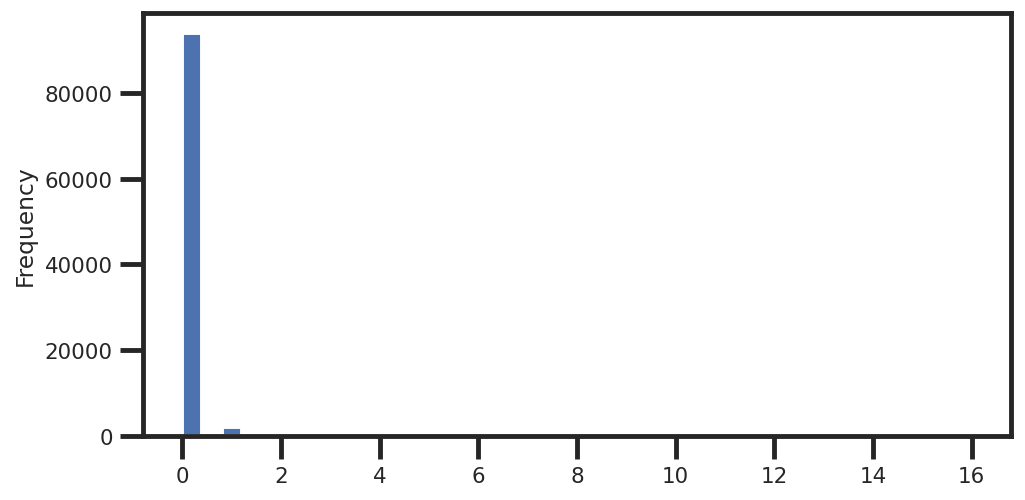

In [91]:
data['frequency'].plot(kind='hist', bins=40)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

Among all customers in our data, more than 97% of them only made purchase once (no repeat)

# Frequency/Recency Analysis Using the BG/NBD Model

In [92]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 96094 subjects, a: 2.48, alpha: 49.66, b: 0.38, r: 0.01>


# Visualizing our frequency/recency matrix
Consider: a customer has made purchase every day for four weeks straight, and then we haven’t heard from him in months. What are the chances he is still “alive”? Pretty small, right? On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given his recency (age at last purchase) and frequency (the number of repeat transactions he has made).

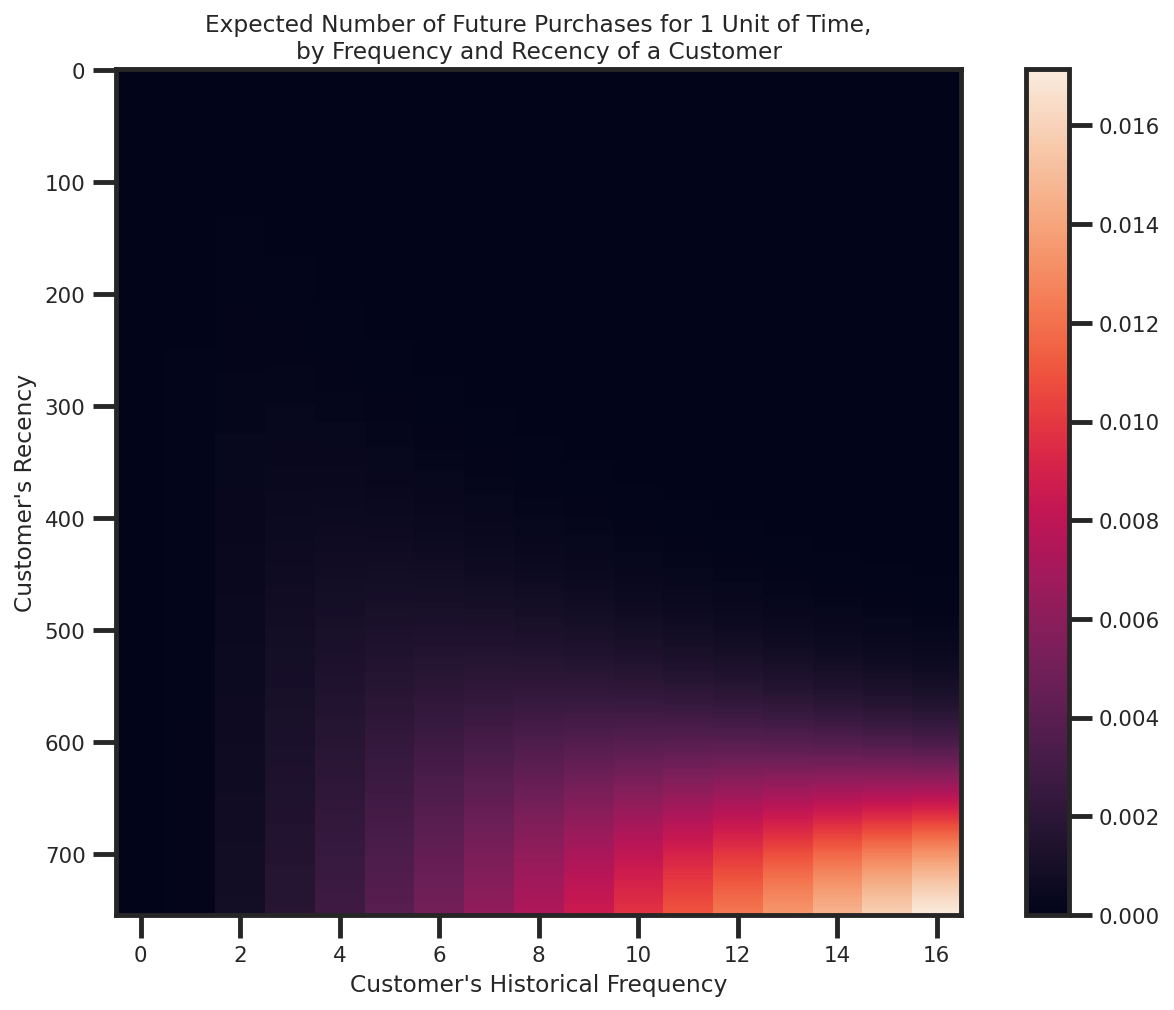

In [93]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

If a customer has made 16 purchases, and his latest purchase was when he was approximately 700 days old (i.e. Recency: the duration between her first transaction and her latest transaction is 700 days), then he is our best customer (bottom-right).

Customers who have purchased a lot but not recently (top-right corner), have probably gone.
There are also another type of customers that around (4, 600) that represents the customer who buys infrequently, and we have not seen him recently, so he might buy again. However, we are not sure if he has gone or just between purchases.

# We can predict which customers are surely alive:

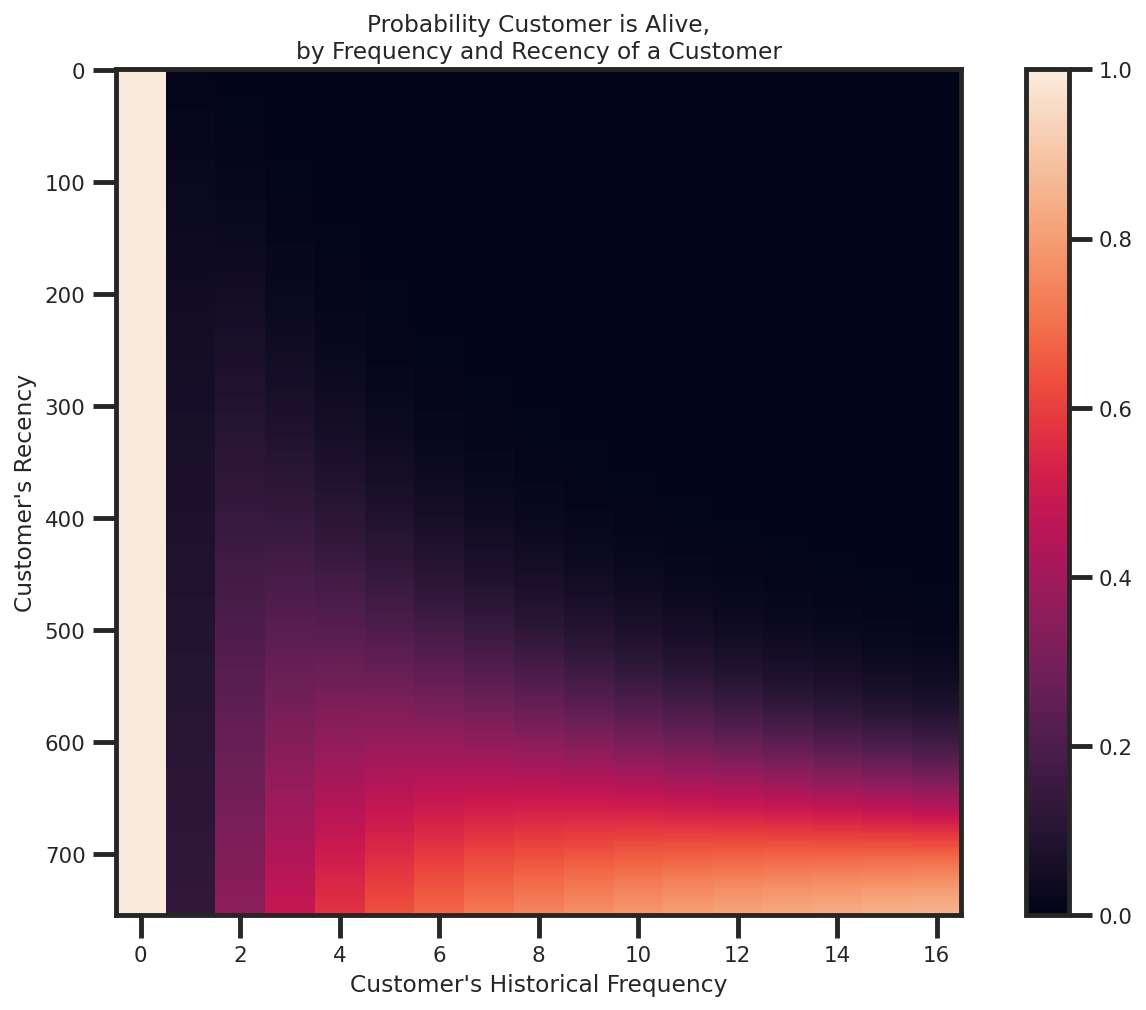

In [97]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

* Customers who have purchased recently are almost surely “alive”.
* Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.
* We are ranking customers from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [101]:
exp = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(exp, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
customer_unique_id,,,,
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,280.0,0.005268
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,454.0,0.005454
ef0103e9602d12594d19c2b666219bc1,2.0,19.0,30.0,0.007307
ba84da8c159659f116329563a0a981dd,2.0,31.0,33.0,0.008352
8d50f5eadf50201ccdcedfb9e2ac8455,16.0,462.0,501.0,0.019056


Listed above are our top 5 customers that the model expects them to make purchases in the next day. The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.

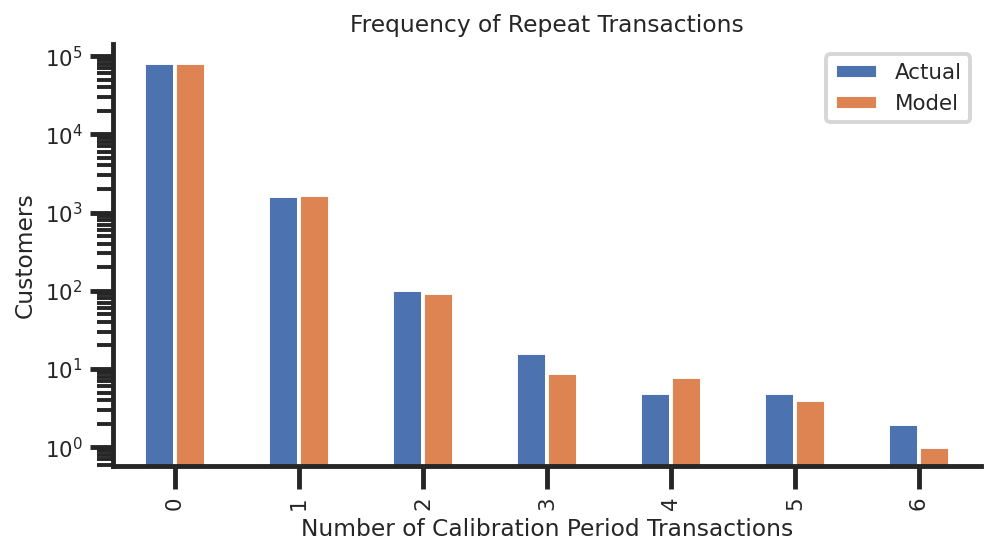

In [150]:
from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(bgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

Not bad, out model does not suck. So, we can continue on with our analysis.
We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice)

In [104]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'customer_unique_id', 'Order_Date',
                                        calibration_period_end='2018-06-30',
                                        observation_period_end='2018-09-28' )   
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,51.0,0.0,90.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,54.0,0.0,90.0
0000f46a3911fa3c0805444483337064,0.0,0.0,477.0,0.0,90.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,261.0,0.0,90.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,228.0,0.0,90.0


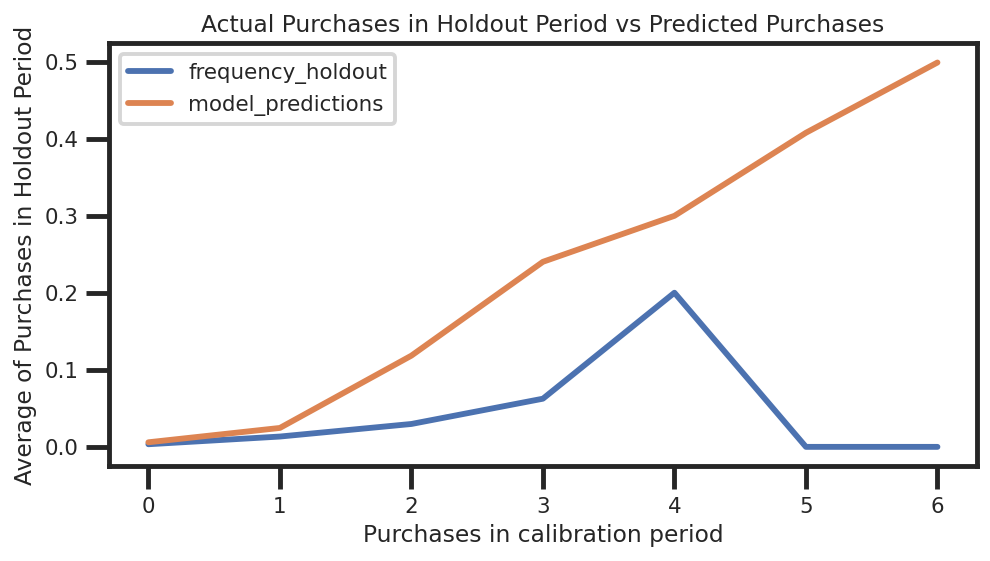

In [105]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In this plot, we separate the data into both a in-sample (calibration) and validation (holdout) period. The sample period consists the beginning to 2018-06-30; the validation period spans from 2018-06-30 to 2018-09-28. The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). The green and blue line presents the model prediction and actual result of the y-axis respectively. As we can see, our model is able to predict the customer base’s behaviour out of the sample, the model under-estimates after 1 purchase.

# Customer transactions predictions# 
Based on customer history, we can now predict what an individual’s future purchases might look like:

In [163]:
t = 30
individual = data.loc['ba84da8c159659f116329563a0a981dd']
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.21562455139194625

Our model predicts that customerID 'ba84da8c159659f116329563a0a981dd' future transaction is 0.215 in 30 days.

In [120]:
returning_customers_summary = data[data['frequency']>0]
display(returning_customers_summary.head())
print(len(returning_customers_summary))

,frequency,recency,T,predicted_purchases
customer_unique_id,,,,
00172711b30d52eea8b313a7f2cced02,1.0,16.0,62.0,0.000740
004288347e5e88a27ded2bb23747066c,1.0,171.0,428.0,0.000138
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,392.0,0.000225
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,221.0,0.000160
00a39521eb40f7012db50455bf083460,1.0,11.0,128.0,0.000278


2147


# Predicting using ModifiedBetaGeoFitter

In [123]:
from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'],
       verbose=True)

Optimization terminated successfully.
         Current function value: 0.085065
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43


<lifetimes.ModifiedBetaGeoFitter: fitted with 83748 subjects, a: 0.22, alpha: 218.09, b: 0.12, r: 0.10>

In [124]:
t = 90 # days to predict in the future 
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      summary_cal_holdout['frequency_cal'], 
                                                                                      summary_cal_holdout['recency_cal'], 
                                                                                      summary_cal_holdout['T_cal'])

summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'], 
                                                                         summary_cal_holdout['recency_cal'], 
                                                                         summary_cal_holdout['T_cal'])
summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive'] / summary_cal_holdout['p_alive'].max(), 2)

In [168]:
display(summary_cal_holdout.sample(2))

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases,p_alive
customer_unique_id,,,,,,,
95638fd4dc72dcc7800e9303a073c38d,0.0,0.0,494.0,0.0,90.0,0.003928,0.33
f8c6675e01e997c8e709c97633faf87b,0.0,0.0,472.0,0.0,90.0,0.004061,0.33
